In [11]:
import os

import matplotlib.pyplot as plt
import mlflow
import numpy as np

from nowcasting.unet import res2
from nowcasting.utils import CustomGenerator

In [12]:
mlflow.set_tracking_uri("../mlruns")

In [13]:
dataset = "12_8_0_12_1.0"
train_directory = f"../data/datasets/{dataset}/train/"
val_directory = f"../data/datasets/{dataset}/val/"

In [14]:
train_paths = [f"{train_directory}/{x}" for x in os.listdir(train_directory)]
train_dataset = CustomGenerator(train_paths, 1, shuffle=False)

val_paths = [f"{val_directory}/{x}" for x in os.listdir(val_directory)]
val_dataset = CustomGenerator(val_paths, 1, shuffle=False)

In [15]:
experiment_id = mlflow.get_experiment_by_name(f"main_test_12_8_0_12_1.0").experiment_id
print(experiment_id)
df = mlflow.search_runs(experiment_id)

259358693577844815


In [16]:
df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.lr,metrics.mae,metrics.val_mae,metrics.loss,...,params.restore_best_weights,params.baseline,params.min_delta,params.patience,params.monitor,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.git.commit,tags.mlflow.runName
0,a55541d1637d4c038b7fc58b62df3159,259358693577844815,FINISHED,file:///panfs/jay/groups/6/csci8523/joren015/r...,2022-11-25 21:40:43.327000+00:00,2022-11-26 06:50:53.262000+00:00,1.000000e-16,0.120182,0.109931,0.120182,...,None,None,None,None,None,LOCAL,main.py,joren015,1ce3cebd37b518cbddbff586c854c57920258690,clumsy-bug-41
1,3392e54d7e9641b19dc7cfbab3c8bb16,259358693577844815,FINISHED,file:///panfs/jay/groups/6/csci8523/joren015/r...,2022-11-25 19:22:00.945000+00:00,2022-11-25 21:20:30.339000+00:00,9.999999e-11,0.119889,0.109428,0.119892,...,False,None,0,20,val_loss,LOCAL,main.py,joren015,1ce3cebd37b518cbddbff586c854c57920258690,crawling-turtle-364


In [17]:
non_zero_runs = []
for i in range(len(df)):
    row = df.iloc[i]
    run_id = row["run_id"]
    num_filters_base = int(row["params.selected_num_filters_base"])
    model = res2((12, 256, 620, 4),
                 num_filters_base=num_filters_base,
                 dropout_rate=0)
    model.load_weights(
        f"../mlruns/{experiment_id}/{run_id}/artifacts/script_n1.h5")
    y_hat = model.predict(val_dataset)
    non_zero_output = np.count_nonzero(y_hat[y_hat > np.mean(y_hat)])
    print(non_zero_output)
    if non_zero_output > 100:
        non_zero_runs.append({
            "weights":
            f"../mlruns/{experiment_id}/{run_id}/artifacts/script_n1.h5",
            "num_filters_base": num_filters_base,
            "non_zero_output": non_zero_output,
            "val_mse": row["metrics.val_mse"]
        })


2022-11-26 19:48:09.358457: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-11-26 19:48:10.111199: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


4/4 [==============================] - 9s 272ms/step
275429
4/4 [==============================] - 7s 230ms/step
4391664


In [18]:
print(len(non_zero_runs))

2


In [19]:
non_zero_run = non_zero_runs[0]
print(non_zero_run)
model = res2((12, 256, 620, 4),
             num_filters_base=non_zero_run["num_filters_base"],
             dropout_rate=0)
model.load_weights(non_zero_run["weights"])
model.compile(loss="mean_absolute_error", metrics=["mae", "mse"])


{'weights': '../mlruns/259358693577844815/a55541d1637d4c038b7fc58b62df3159/artifacts/script_n1.h5', 'num_filters_base': 4, 'non_zero_output': 275429, 'val_mse': 1.0466601848602295}


In [20]:
model.evaluate(train_dataset)

35/35 [==============================] - 17s 237ms/step - loss: 0.1240 - mae: 0.1240 - mse: 1.5372


[0.12398343533277512, 0.12398343533277512, 1.5372264385223389]

In [21]:
model.evaluate(val_dataset)

4/4 [==============================] - 1s 237ms/step - loss: 0.1342 - mae: 0.1342 - mse: 2.1561


[0.1341967135667801, 0.1341967135667801, 2.1560513973236084]

In [22]:
y_pred = model.predict(val_dataset)

4/4 [==============================] - 7s 230ms/step


In [23]:
print(np.min(y_pred))

1.7017703e-08


In [24]:
k = 0
X, y = train_dataset.__getitem__(k)
X = X[0]
y = y[0]
y_hat = y_pred[k]

Input


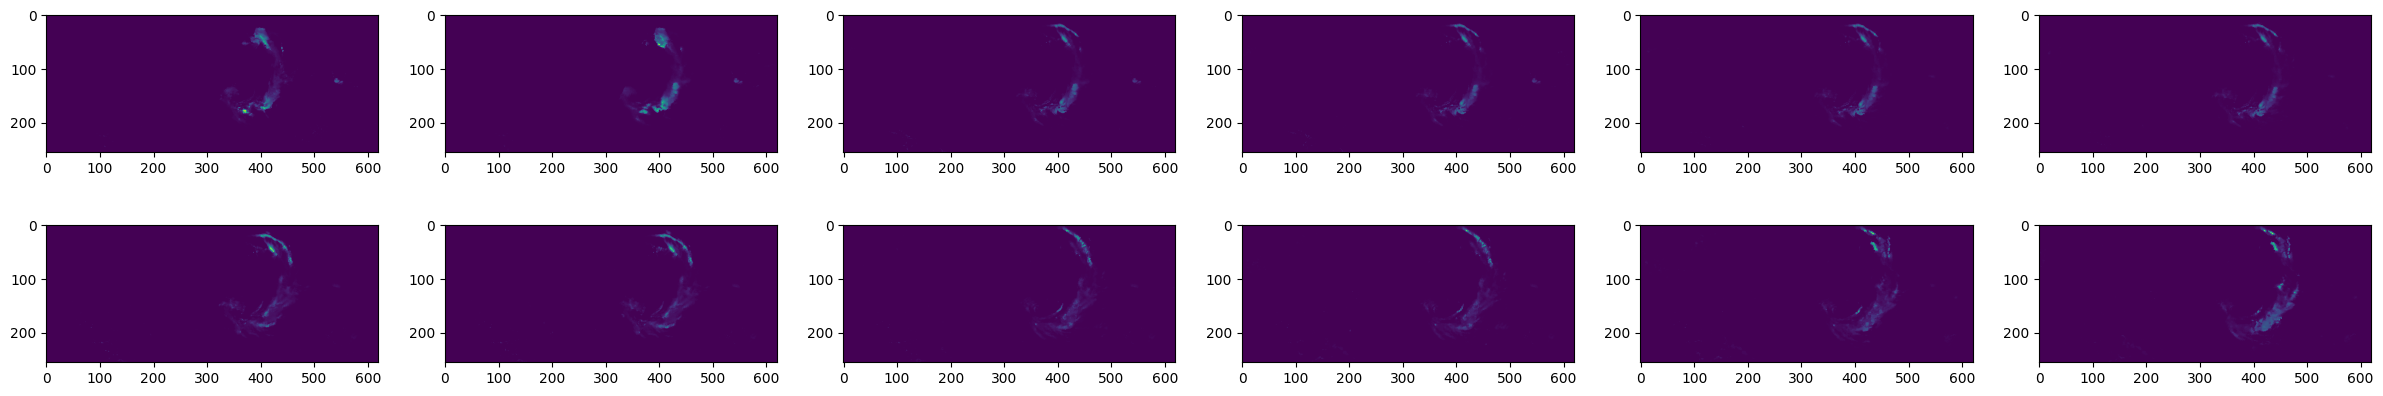

In [25]:
print("Input")
fig, axs = plt.subplots(2, 6, figsize=(30, 5))

for i in range(2):
    for j in range(6):
        axs[i, j].imshow(X[i * 6 + j, :, :, 0])

Target


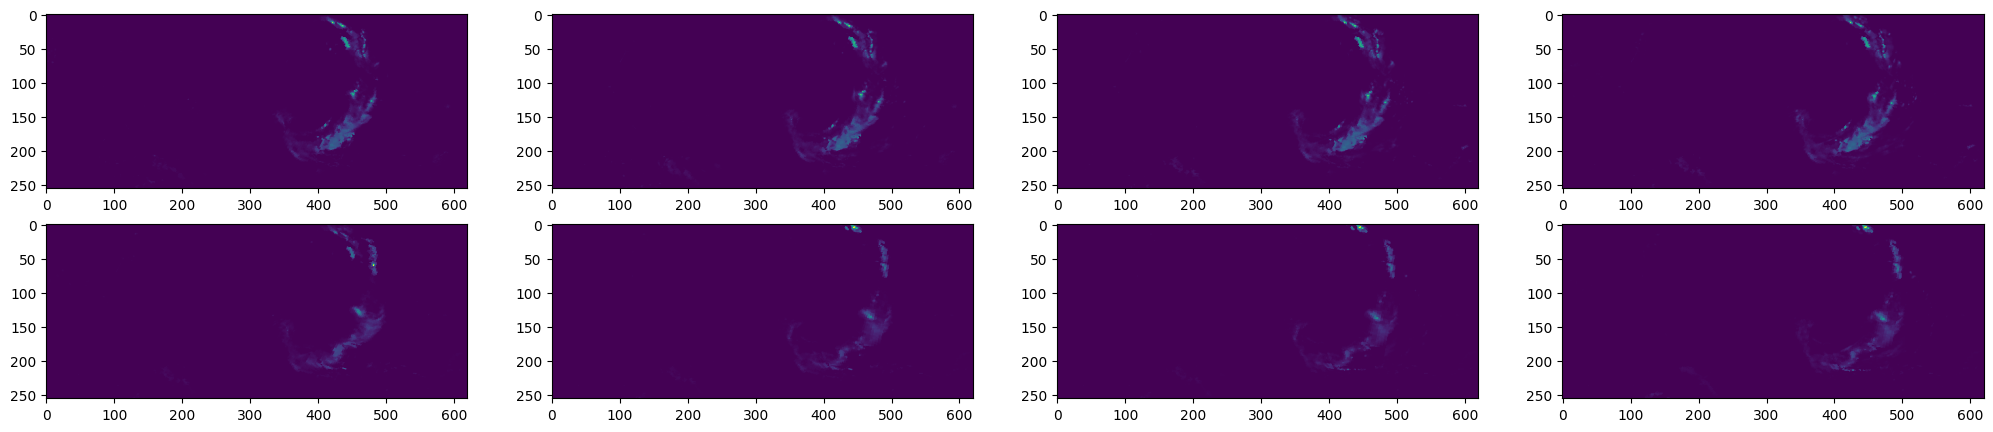

In [26]:
print("Target")
fig, axs = plt.subplots(2, 4, figsize=(25, 5))

for i in range(2):
    for j in range(4):
        axs[i, j].imshow(y[i * 4 + j, :, :, 0])

Prediction


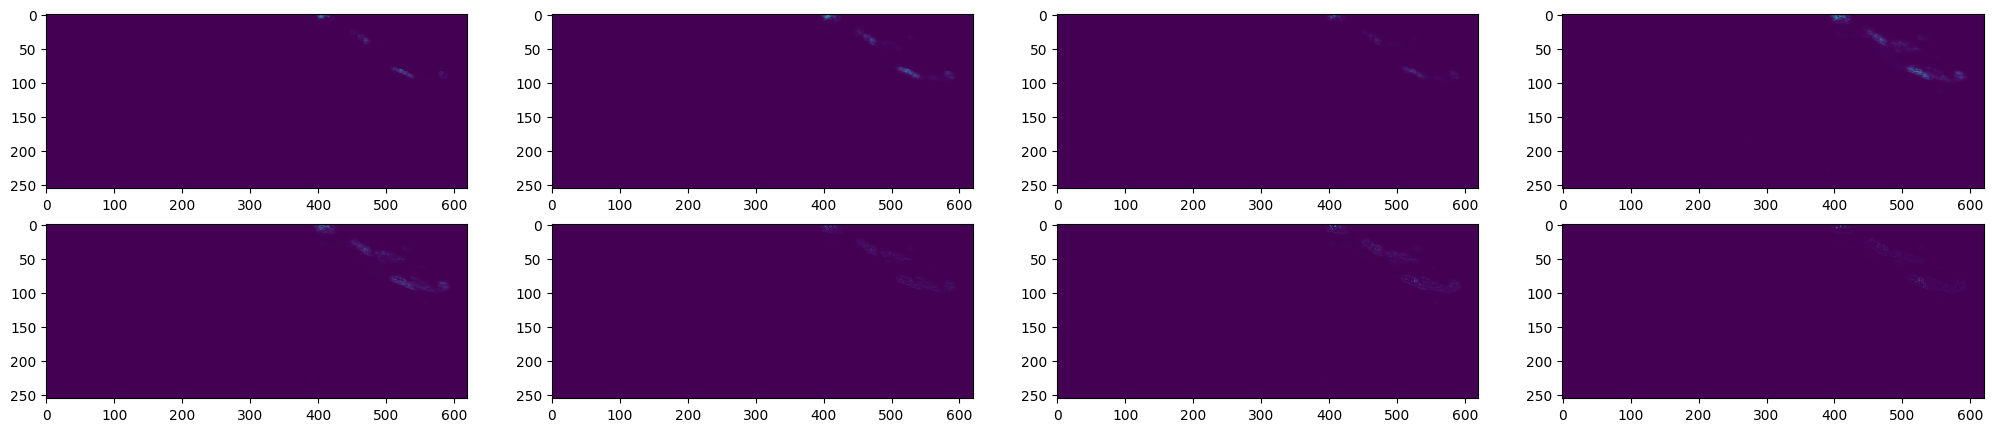

In [27]:
print("Prediction")
fig, axs = plt.subplots(2, 4, figsize=(25, 5))

for i in range(2):
    for j in range(4):
        axs[i, j].imshow(y_hat[i * 4 + j, :, :])

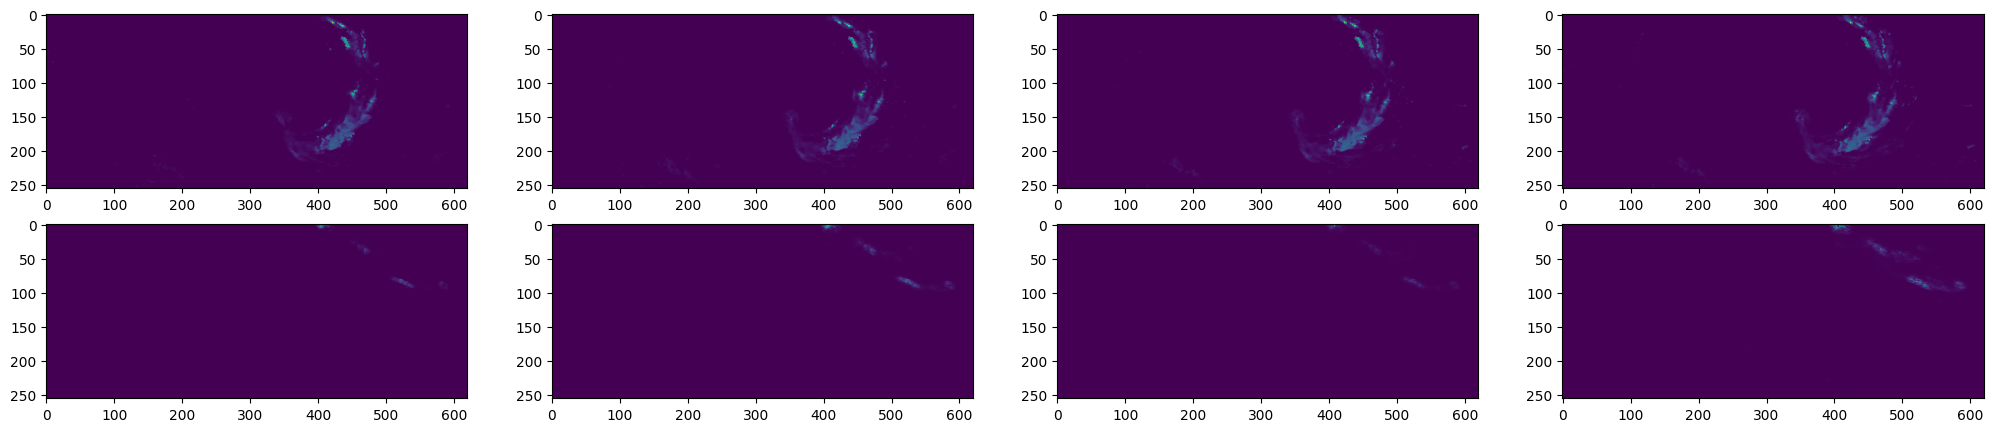

In [28]:
fig, axs = plt.subplots(2, 4, figsize=(25, 5))

for j in range(4):
    axs[0, j].imshow(y[j, :, :, 0])
    axs[1, j].imshow(y_hat[j, :, :])